We set target vol to 10% per annum to ensure fair return (and bc it is also the case in the paper)
Without rescaling, a strategy with higher volatility would naturally dominate the P&L simply because it takes bigger bets. By scaling everything to 10% volatility, we equalize the risk budget. If one strategy makes more money than another after this scaling, it is because it is more efficient (higher Sharpe Ratio), not just riskier

Pool of Strategies: ['DOL', 'CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

--- Strategy Performance Statistics ---
              Ann. Mean  Ann. Vol    Sharpe
Naive          0.102166  0.105979  0.964025
Mean           0.081646  0.105198  0.776118
Volatility     0.107014  0.107790  0.992796
Sharpe         0.085223  0.107238  0.794709
Top-3          0.100026  0.115446  0.866437
Max Return     0.121627  0.151746  0.801521
Min Variance   0.124757  0.150882  0.826854


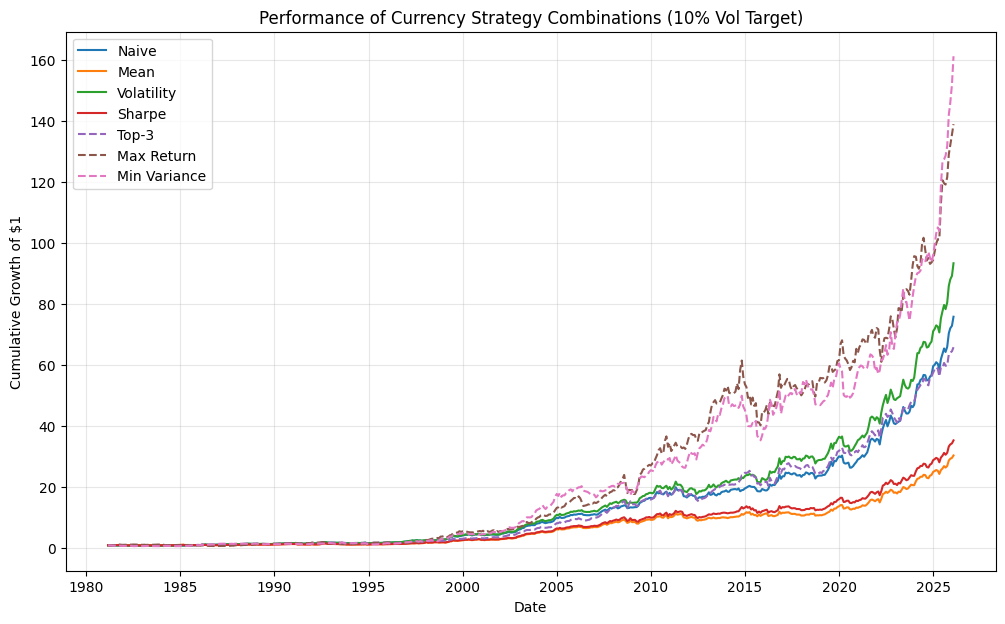

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize



df = pd.read_excel('../data/Factors_Net.xlsx')


if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('date', inplace=True)


strategies = ['DOL', 'CAR', 'VAL', 'M1M', 'M3M',
                'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

# Filter for columns that actually exist in the file
available_strategies = [col for col in strategies if col in df.columns]
print(f"Pool of Strategies: {available_strategies}")

returns = df[available_strategies].dropna()
    
target_vol_ann = 0.10
target_vol_m = target_vol_ann / np.sqrt(12)
window = 60  # 5-year rolling window

# Storage
# We will store the *returns* of each combined strategy
combined_results = pd.DataFrame(index=returns.index[window:],
                                columns=['Naive', 'Mean', 'Volatility', 'Sharpe',
                                            'Top-3', 'Max Return', 'Min Variance'])

# Rolling Window Loop
for t in range(window, len(returns)):
    # Data available up to t-1
    past_returns = returns.iloc[t-window:t]

    # --- Inputs for Optimization ---
    mu = past_returns.mean()
    sigma = past_returns.cov()
    inv_sigma = np.linalg.pinv(sigma)  # Pseudo-inverse for stability
    vols = np.sqrt(np.diag(sigma))

    w_naive = np.ones(len(available_strategies)) / \
        len(available_strategies)

    # --- 2. Mean Combination ---
    w_mean = mu.values

    # --- 3. Volatility Combination (Inverse Vol) ---
    w_vol = 1.0 / vols

    # --- 4. Sharpe Combination (Heuristic) ---
    with np.errstate(divide='ignore', invalid='ignore'):
        w_sharpe_h = mu.values / vols
        w_sharpe_h[~np.isfinite(w_sharpe_h)] = 0.0

    # --- 5. Top-3 Combination ---
    # Calculate historical Sharpe for ranking
    hist_sharpe = mu / vols
    # Get indices of top 3
    top3_indices = hist_sharpe.nlargest(3).index
    # Create weight vector
    w_top3 = pd.Series(0.0, index=available_strategies)
    w_top3[top3_indices] = 1.0 / 3.0  # Equal weight to top 3
    w_top3 = w_top3.values

    # --- 6. Maximum Return (Mean-Variance) ---
    # Maximize Returns s.t. Vol = Target
    # Analytical solution: w proportional to Sigma^-1 * Mu
    w_maxret = inv_sigma @ mu.values

    # --- 7. Minimum Variance ---
    # Minimize Variance s.t. Sum(w)=1
    # Analytical solution: w proportional to Sigma^-1 * 1
    ones = np.ones(len(available_strategies))
    w_minvar = inv_sigma @ ones
    w_minvar = w_minvar / np.sum(w_minvar)  # Normalize to sum to 1

    # --- Volatility Scaling & Return Calculation ---
    # Apply scaling to ALL strategies to meet target volatility

    weight_dict = {
        'Naive': w_naive,
        'Mean': w_mean,
        'Volatility': w_vol,
        'Sharpe': w_sharpe_h,
        'Top-3': w_top3,
        'Max Return': w_maxret,
        'Min Variance': w_minvar
    }

    r_t = returns.iloc[t]  # Realized return for this month

    for name, w_raw in weight_dict.items():
        # Calculate ex-ante portfolio vol
        p_var = w_raw @ sigma @ w_raw.T
        p_vol = np.sqrt(p_var)

        # Scale weights
        if p_vol > 0:
            scaler = target_vol_m / p_vol
            w_final = w_raw * scaler
        else:
            w_final = w_raw

        # Store realized return
        combined_results.loc[returns.index[t],
                                name] = np.dot(w_final, r_t.values)

# 3. Statistics & Plotting
# ---------------------------------------------------------
combined_results = combined_results.apply(pd.to_numeric)

# Calculate Stats
def get_stats(series):
    ann_mean = series.mean() * 12
    ann_vol = series.std() * np.sqrt(12)
    sharpe = ann_mean / ann_vol if ann_vol != 0 else 0
    return pd.Series({'Ann. Mean': ann_mean, 'Ann. Vol': ann_vol, 'Sharpe': sharpe})

stats_df = combined_results.apply(get_stats)
print("\n--- Strategy Performance Statistics ---")
print(stats_df.T)  # Transpose for readability

# Plot
cumulative = (1 + combined_results).cumprod()

plt.figure(figsize=(12, 7))
for col in cumulative.columns:
    # Use dashed lines for the new strategies to distinguish
    style = '--' if col in ['Top-3', 'Max Return', 'Min Variance'] else '-'
    plt.plot(cumulative.index, cumulative[col], label=col, linestyle=style)

plt.title('Performance of Currency Strategy Combinations (10% Vol Target)')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


--- Strategy Performance Statistics ---
                 Ann. Mean  Ann. Vol    Sharpe   Sortino
Naive             0.108962  0.111607  0.976306  1.668789
Mean              0.088244  0.113907  0.774699  1.249026
Volatility        0.111730  0.112433  0.993752  1.714199
Sharpe            0.091061  0.114374  0.796172  1.293591
Top-3             0.098535  0.115300  0.854595  1.449179
Max Return        0.103880  0.116451  0.892046  1.537796
Min Variance      0.108188  0.118604  0.912181  1.593546
Downside Parity   0.112060  0.114695  0.977027  1.673066


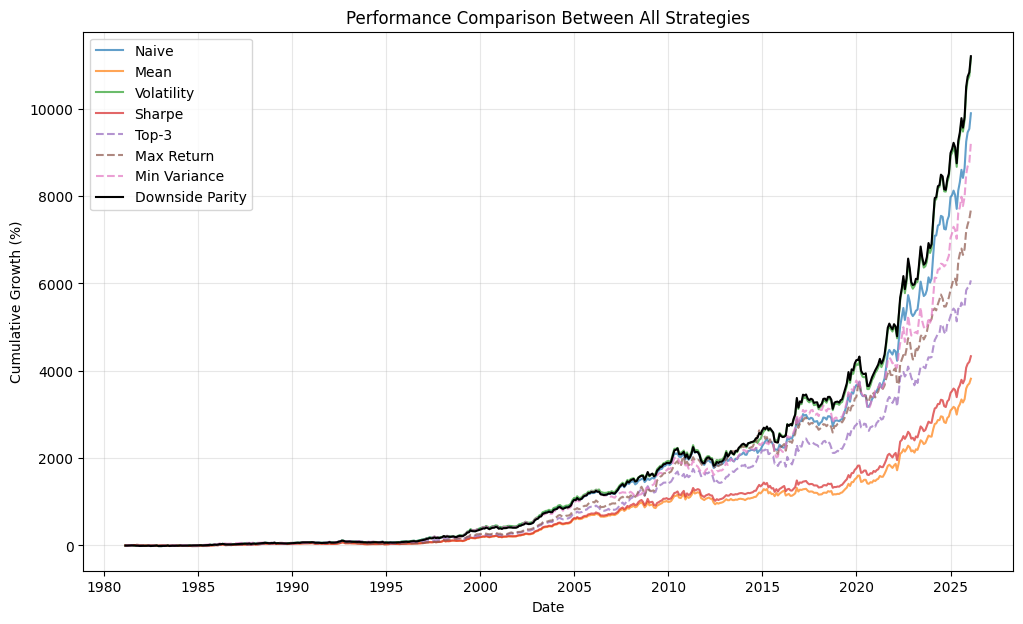

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# 1. Load Data
# ---------------------------------------------------------
try:
    df = pd.read_excel('../data/Factors_Net.xlsx')

    # Parse dates
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df.set_index('date', inplace=True)

    # Strategies to combine
    strategies = ['CAR', 'VAL', 'M1M', 'M3M',
                  'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']
    available_strategies = [col for col in strategies if col in df.columns]
    returns = df[available_strategies].dropna()

except Exception as e:
    print(f"Error loading data: {e}")
    returns = pd.DataFrame()

# 2. Strategy Logic
# ---------------------------------------------------------
if not returns.empty:
    # Parameters
    target_vol_ann = 0.10
    target_vol_m = target_vol_ann / np.sqrt(12)
    window = 60  # 5-year rolling window

    # Risk-free rate (CHANGE if needed)
    rf_ann = 0.0
    rf_m = rf_ann / 12

    # Storage
    cols = ['Naive', 'Mean', 'Volatility', 'Sharpe', 'Top-3',
            'Max Return', 'Min Variance', 'Downside Parity']
    combined_results = pd.DataFrame(index=returns.index[window:], columns=cols)

    # Rolling Window Loop
    for t in range(window, len(returns)):
        past_returns = returns.iloc[t-window:t]

        # --- Standard Estimates ---
        mu = past_returns.mean()

        # Covariance (Ledoit-Wolf)
        lw = LedoitWolf()
        try:
            lw.fit(past_returns)
            sigma = lw.covariance_
        except:
            sigma = past_returns.cov().values

        inv_sigma = np.linalg.pinv(sigma)
        vols = np.sqrt(np.diag(sigma))

        # --- Downside Estimates ---
        neg_rets = past_returns.copy()
        neg_rets[neg_rets > 0] = 0
        semi_vols = np.sqrt((neg_rets**2).mean())
        semi_vols[semi_vols == 0] = 1e-6

        # --- 1. Naive (1/N) ---
        w_naive = np.ones(len(available_strategies)) / \
            len(available_strategies)

        # --- 2. Mean ---
        w_mean = mu.values

        # --- 3. Volatility (Risk Parity) ---
        w_vol = 1.0 / vols

        # --- 4. Sharpe ---
        with np.errstate(divide='ignore', invalid='ignore'):
            w_sharpe = mu.values / vols
            w_sharpe[~np.isfinite(w_sharpe)] = 0.0

        # --- 5. Top-3 (Momentum) ---
        hist_sharpe = mu / vols
        top3_indices = hist_sharpe.nlargest(3).index
        w_top3 = pd.Series(0.0, index=available_strategies)
        idx_map = {name: i for i, name in enumerate(available_strategies)}
        for name in top3_indices:
            w_top3.iloc[idx_map[name]] = 1.0 / 3.0
        w_top3 = w_top3.values

        # --- 6. Max Return (MV) ---
        w_maxret = inv_sigma @ mu.values

        # --- 7. Min Variance ---
        ones = np.ones(len(available_strategies))
        w_minvar = inv_sigma @ ones
        w_minvar = w_minvar / np.sum(w_minvar)

        # --- 8. Downside Risk Parity ---
        w_downside = 1.0 / semi_vols.values

        # --- Volatility Scaling & Return Calculation ---
        weight_dict = {
            'Naive': w_naive,
            'Mean': w_mean,
            'Volatility': w_vol,
            'Sharpe': w_sharpe,
            'Top-3': w_top3,
            'Max Return': w_maxret,
            'Min Variance': w_minvar,
            'Downside Parity': w_downside
        }

        r_t = returns.iloc[t]

        for name, w_raw in weight_dict.items():
            p_var = w_raw @ sigma @ w_raw.T
            p_vol = np.sqrt(p_var)

            if p_vol > 0:
                scaler = target_vol_m / p_vol
                w_final = w_raw * scaler
            else:
                w_final = w_raw

            combined_results.loc[returns.index[t],
                                 name] = np.dot(w_final, r_t.values)

    # 3. Statistics & Plotting
    # ---------------------------------------------------------
    combined_results = combined_results.apply(pd.to_numeric)

    def get_stats(series):
        # Excess returns
        excess = series - rf_m

        # Annualized mean excess return
        ann_mean = excess.mean() * 12

        # Annualized volatility
        ann_vol = series.std() * np.sqrt(12)

        # Sharpe
        sharpe = ann_mean / ann_vol if ann_vol != 0 else 0

        # --- Sortino ---
        downside = excess.copy()
        downside[downside > 0] = 0

        downside_dev_m = np.sqrt((downside**2).mean())
        downside_dev_ann = downside_dev_m * np.sqrt(12)

        sortino = ann_mean / downside_dev_ann if downside_dev_ann != 0 else 0

        return pd.Series({
            'Ann. Mean': ann_mean,
            'Ann. Vol': ann_vol,
            'Sharpe': sharpe,
            'Sortino': sortino
        })

    stats_df = combined_results.apply(get_stats)
    print("\n--- Strategy Performance Statistics ---")
    print(stats_df.T)

    # Plot % Cumulative Growth
    cumulative = (1 + combined_results).cumprod()
    cumulative_pct = (cumulative - 1) * 100

    plt.figure(figsize=(12, 7))
    for col in cumulative_pct.columns:
        if col == 'Downside Parity':
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, color='black')
        else:
            style = '--' if col in ['Top-3',
                                    'Max Return', 'Min Variance'] else '-'
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, linestyle=style, alpha=0.7)

    plt.title('Performance Comparison Between All Strategies')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [3]:
stats_df.T.sort_values(by='Sharpe').to_excel("../data/results_stats_combination.xlsx")

In [4]:
strategies = ['CAR', 'VAL', 'M1M', 'M3M',
              'M6M', 'M1Y']

df_master = pd.DataFrame()

for strat in strategies:
    df_tmp = pd.read_excel(f"../data/Portfolios_Net_{strat}.xlsx")
    df_tmp['date'] = pd.to_datetime(df_tmp['date'], format='%Y%m%d')
    df_tmp.set_index('date', inplace=True)

    df_tmp.columns = df_tmp.columns + strat
    if df_master.empty:
        df_master = df_tmp
    else:
        df_master = df_master.join(df_tmp, how='inner')

df_master.to_excel("../data/portfolios.xlsx")

In [5]:
df_master['DOL'] = df['DOL']
df_master['CAR'] = df['CAR']

df_master = df_master.dropna()

In [6]:
import statsmodels.api as sm

portfolios = [col for col in df_master.columns if col.startswith('P')]
len(portfolios)

30

In [30]:
X_ts = sm.add_constant(df_master[['DOL', 'CAR']])
betas = pd.DataFrame(index=portfolios, columns=[
                     'const', 'beta_DOL', 'beta_CAR'])

for port in portfolios:
    model_ts = sm.OLS(df_master[port], X_ts).fit()
    betas.loc[port, 'const'] = model_ts.params['const']
    betas.loc[port, 'beta_DOL'] = model_ts.params['DOL']
    betas.loc[port, 'beta_CAR'] = model_ts.params['CAR']

betas = betas.astype(float)
print("--- Average Factor Loadings (Betas) ---")
print(betas[['beta_DOL', 'beta_CAR']].describe().loc[['mean', 'min', 'max']])

# ==========================================
# STEP 2: Cross-Sectional Regressions (Lambdas)
# ==========================================
# We run the regression *without* a constant because beta_DOL is approx 1 for all portfolios,
# which would cause severe multicollinearity with an intercept.
X_cs = betas[['beta_DOL', 'beta_CAR']]
lambdas = []

for t in df_master.index:
    y_t = df_master.loc[t, portfolios].astype(float)
    model_cs = sm.OLS(y_t, X_cs).fit()
    lambdas.append(model_cs.params)

# ==========================================
# STEP 3: Fama-MacBeth Estimates
# ==========================================
lambdas_df = pd.DataFrame(lambdas, index=df_master.index)
fm_estimates = lambdas_df.mean()

# Standard Error of the mean (Standard Fama-MacBeth standard errors)
fm_se = lambdas_df.std() / np.sqrt(len(lambdas_df))
fm_tstats = fm_estimates / fm_se

# Format and display results (Annualized for readability)
results = pd.DataFrame({
    'Risk Premium (Ann. %)': fm_estimates * 12 * 100,
    'Std Error (Ann. %)': fm_se * 12 * 100,
    't-stat': fm_tstats
})

print("\n--- Fama-MacBeth Factor Prices of Risk (No Intercept) ---")
print(results)

--- Average Factor Loadings (Betas) ---
      beta_DOL  beta_CAR
mean  1.000066  0.007054
min   0.882491 -0.394309
max   1.113137  0.605691

--- Fama-MacBeth Factor Prices of Risk (No Intercept) ---
          Risk Premium (Ann. %)  Std Error (Ann. %)    t-stat
beta_DOL               1.444391            0.976639  1.478941
beta_CAR               7.652020            1.220828  6.267895


beta_DOL      0.001126
beta_CAR      0.005272
beta_VOL_z   -0.000031
dtype: float64

In [8]:
df_vol = pd.read_excel('../data/GRVOL.xlsx')
# Parse the numeric dates (e.g., 19700129) to datetime
df_vol['date'] = pd.to_datetime(df_vol['date'].astype(str), format='%Y%m%d')
df_vol.set_index('date', inplace=True)
df_vol = df_vol.dropna()
df_vol['YM'] = df_vol.index.to_period('M')
df_vol.set_index('YM', inplace=True)

In [23]:
# df_vol['log_vol'] = np.log(df_vol['vol'])
# df_vol['d_log_vol'] = df_vol['log_vol'].diff()
# df_vol = df_vol.dropna()
df_vol

,vol,log_vol,d_log_vol
YM,,,
1970-03,0.005272,-5.245305,-0.891443
1970-04,0.006197,-5.083701,0.161604
1970-05,0.009771,-4.628354,0.455347
1970-06,0.023397,-3.755165,0.873189
1970-07,0.011268,-4.485753,-0.730587
...,...,...,...
2025-09,0.055562,-2.890258,-0.057030
2025-10,0.059590,-2.820259,0.069999
2025-11,0.052210,-2.952474,-0.132215


In [10]:
# df_master = df_master.join(df_vol, how='inner')
df_master['YM'] = df_master.index.to_period('M')
df_master.set_index('YM', inplace=True)
df_master

,P1CAR,P2CAR,P3CAR,P4CAR,P5CAR,P1VAL,P2VAL,P3VAL,P4VAL,P5VAL,...,P3M6M,P4M6M,P5M6M,P1M1Y,P2M1Y,P3M1Y,P4M1Y,P5M1Y,DOL,CAR
YM,,,,,,,,,,,,,,,,,,,,,
1976-02,0.003604,-0.002586,0.008406,-0.001913,-0.055167,0.003361,-0.000408,-0.000865,-0.055056,0.007343,...,-0.001936,0.000044,0.013798,0.002823,-0.002663,-0.002653,-0.039321,0.010003,-0.006629,-0.058770
1976-03,0.004617,0.004566,-0.012106,-0.023544,-0.037682,0.008536,0.004444,-0.007096,-0.012389,-0.065885,...,-0.006735,-0.007177,0.005237,-0.024769,-0.015489,-0.006735,-0.007177,0.005237,-0.011215,-0.042299
1976-04,0.002950,0.002245,-0.005381,0.003877,-0.020984,0.004122,0.002960,0.008347,0.003467,-0.042644,...,0.002245,0.004930,0.010147,-0.027870,0.004425,0.002245,0.004930,0.010147,-0.002435,-0.023935
1976-05,-0.008550,-0.013698,-0.016149,-0.010920,0.021892,-0.005630,-0.018326,-0.011784,-0.012536,0.022261,...,-0.013698,-0.007191,-0.005514,0.016220,-0.025949,-0.013698,-0.007191,-0.005514,-0.007553,0.030442
1976-06,0.002956,-0.000080,0.006309,-0.003006,0.012213,0.000827,0.004577,0.000228,-0.003006,0.019402,...,0.001758,0.001829,0.003348,0.016221,-0.007219,0.001758,0.001829,0.003348,0.002889,0.009257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09,-0.003268,0.001621,0.000056,0.012302,0.005286,0.009146,0.000981,0.003144,-0.003897,0.005441,...,0.007087,0.008126,0.004730,-0.002876,-0.002601,0.002731,0.009447,0.009521,0.002989,0.008554
2025-10,-0.015374,-0.007015,-0.000668,-0.003693,0.033635,-0.008223,-0.006737,-0.001789,-0.000843,0.024113,...,-0.012484,-0.012180,0.031416,-0.006440,-0.001501,-0.010565,-0.008575,0.033687,0.000896,0.049009
2025-11,-0.000631,0.000997,0.002501,0.003337,0.010556,0.001302,0.003899,0.012068,-0.004655,0.002189,...,0.010502,0.002710,0.005045,-0.005006,0.003109,0.006223,0.000610,0.010965,0.003210,0.011187


In [ ]:
df_master = df_master.join(df_vol['d_log_vol'], how='inner')

In [ ]:
X_ts = sm.add_constant(df_master[['DOL', 'CAR', 'd_log_vol']])
betas = pd.DataFrame(index=portfolios, columns=['const', 'beta_DOL', 'beta_CAR', 'beta_VOL'])

In [ ]:
for port in portfolios:
    model_ts = sm.OLS(df_master[port], X_ts).fit()
    betas.loc[port, 'const'] = model_ts.params['const']
    betas.loc[port, 'beta_DOL'] = model_ts.params['DOL']
    betas.loc[port, 'beta_CAR'] = model_ts.params['CAR']
    #betas.loc[port, 'beta_VOL'] = model_ts.params['d_log_vol']

betas = betas.astype(float)
print("--- Average Factor Loadings (Betas) ---")
print(betas[['beta_DOL', 'beta_CAR', 'beta_VOL']
            ].describe().loc[['mean', 'min', 'max']])

--- Average Factor Loadings (Betas) ---
      beta_DOL  beta_CAR  beta_VOL
mean  1.000052  0.007019 -0.000011
min   0.873273 -0.395110 -0.007068
max   1.117225  0.604890  0.007345


In [14]:
# ==========================================
# STEP 2: Cross-Sectional Regressions (Lambdas)
# ==========================================
X_cs = betas[['beta_DOL', 'beta_CAR', 'beta_VOL']]
lambdas = []

for t in df_master.index:
    y_t = df_master.loc[t, portfolios].astype(float)
    model_cs = sm.OLS(y_t, X_cs).fit()
    lambdas.append(model_cs.params)

In [15]:
# ==========================================
# STEP 3: Fama-MacBeth Estimates
# ==========================================
lambdas_df = pd.DataFrame(lambdas, index=df_master.index)
fm_estimates = lambdas_df.mean()
fm_se = lambdas_df.std() / np.sqrt(len(lambdas_df))
fm_tstats = fm_estimates / fm_se

results = pd.DataFrame({
    'Risk Premium (Ann. %)': fm_estimates * 12 * 100,
    'Std Error (Ann. %)': fm_se * 12 * 100,
    't-stat': fm_tstats
})

print("\n--- Fama-MacBeth Factor Prices of Risk (No Intercept) ---")
print(results)


--- Fama-MacBeth Factor Prices of Risk (No Intercept) ---
          Risk Premium (Ann. %)  Std Error (Ann. %)    t-stat
beta_DOL               1.447214            0.976629  1.481846
beta_CAR               7.458765            1.165196  6.401296
beta_VOL             -51.477394           44.749289 -1.150351


In [19]:
portfolios = [col for col in df_master.columns if col.startswith('P')]

# Paramètres de la fenêtre glissante
window = 60  # 60 mois = 5 ans
lambdas_rolling = []
dates_rolling = []

# Boucle Fama-MacBeth avec fenêtre glissante
for t in range(window, len(df_master)):

    # 1. Données d'entraînement (Les 60 derniers mois : de t-window à t-1)
    train_data = df_master.iloc[t-window: t]

    # 2. Données de test (Le mois exact t)
    test_data = df_master.iloc[t]

    # --- Étape 1 : Régressions Temporelles (Estimation des Betas sur la fenêtre) ---
    X_ts = sm.add_constant(train_data[['DOL', 'CAR', 'd_log_vol']])
    betas_t = pd.DataFrame(index=portfolios, columns=[
                           'beta_DOL', 'beta_CAR', 'beta_VOL'])

    for port in portfolios:
        model_ts = sm.OLS(train_data[port], X_ts).fit()
        betas_t.loc[port, 'beta_DOL'] = model_ts.params['DOL']
        betas_t.loc[port, 'beta_CAR'] = model_ts.params['CAR']
        betas_t.loc[port, 'beta_VOL'] = model_ts.params['d_log_vol']

    betas_t = betas_t.astype(float)

    # --- Étape 2 : Régression Transversale (Estimation des primes de risque au mois t) ---
    X_cs = betas_t[['beta_DOL', 'beta_CAR', 'beta_VOL']]
    y_t = test_data[portfolios].astype(float)

    # Fit OLS SANS constante (pour éviter la colinéarité avec DOL)
    model_cs = sm.OLS(y_t, X_cs).fit()

    # Sauvegarde des lambdas et de la date
    lambdas_rolling.append(model_cs.params)
    dates_rolling.append(df_master.index[t])

# ==========================================
# ÉTAPE 3 : Moyennes de Fama-MacBeth
# ==========================================
lambdas_df = pd.DataFrame(lambdas_rolling, index=dates_rolling)

fm_estimates = lambdas_df.mean()
fm_se = lambdas_df.std() / np.sqrt(len(lambdas_df))
fm_tstats = fm_estimates / fm_se

results = pd.DataFrame({
    'Risk Premium (Ann. %)': fm_estimates * 12 * 100,
    'Std Error (Ann. %)': fm_se * 12 * 100,
    't-stat': fm_tstats
})

print("--- Rolling Window (60-month) Factor Prices of Risk ---")
print(results)

--- Rolling Window (60-month) Factor Prices of Risk ---
          Risk Premium (Ann. %)  Std Error (Ann. %)    t-stat
beta_DOL               1.340048            0.981965  1.364660
beta_CAR               6.328115            1.024586  6.176264
beta_VOL             -22.613322           32.167033 -0.702997


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Identifier les 30 portefeuilles
portfolios = [col for col in df_master.columns if col.startswith('P')]

# Paramètres de la fenêtre glissante
window = 60  # 60 mois = 5 ans
lambdas_rolling = []
dates_rolling = []

# Boucle Fama-MacBeth avec fenêtre glissante
for t in range(window, len(df_master)):

    train_data = df_master.iloc[t-window: t]
    test_data = df_master.iloc[t]

    # --- Étape 1 : Régressions Temporelles (Estimation des Betas sur la fenêtre) ---
    X_ts = sm.add_constant(train_data[['DOL', 'CAR', 'd_log_vol']])
    betas_t = pd.DataFrame(index=portfolios, columns=[
                           'beta_DOL', 'beta_CAR', 'beta_VOL'])

    for port in portfolios:
        model_ts = sm.OLS(train_data[port], X_ts).fit()
        betas_t.loc[port, 'beta_DOL'] = model_ts.params['DOL']
        betas_t.loc[port, 'beta_CAR'] = model_ts.params['CAR']
        betas_t.loc[port, 'beta_VOL'] = model_ts.params['d_log_vol']

    betas_t = betas_t.astype(float)

    # ==========================================
    # NOUVEAU : Standardisation Transversale (Z-score)
    # ==========================================
    beta_vol_mean = betas_t['beta_VOL'].mean()
    beta_vol_std = betas_t['beta_VOL'].std()

    if beta_vol_std != 0:
        betas_t['beta_VOL_z'] = (
            betas_t['beta_VOL'] - beta_vol_mean) / beta_vol_std
    else:
        betas_t['beta_VOL_z'] = betas_t['beta_VOL']

    # --- Étape 2 : Régression Transversale (Estimation des primes de risque au mois t) ---
    # On utilise beta_VOL_z à la place du beta_VOL brut
    X_cs = betas_t[['beta_DOL', 'beta_CAR', 'beta_VOL_z']]
    y_t = test_data[portfolios].astype(float)

    # Fit OLS SANS constante
    model_cs = sm.OLS(y_t, X_cs).fit()

    lambdas_rolling.append(model_cs.params)
    dates_rolling.append(df_master.index[t])

# ==========================================
# ÉTAPE 3 : Moyennes de Fama-MacBeth
# ==========================================
lambdas_df = pd.DataFrame(lambdas_rolling, index=dates_rolling)

fm_estimates = lambdas_df.mean()
fm_se = lambdas_df.std() / np.sqrt(len(lambdas_df))
fm_tstats = fm_estimates / fm_se

results = pd.DataFrame({
    'Risk Premium (Ann. %)': fm_estimates * 12 * 100,
    'Std Error (Ann. %)': fm_se * 12 * 100,
    't-stat': fm_tstats
})

print("--- Rolling Window (60-month) Factor Prices of Risk (Standardized VOL) ---")
print(results)

--- Rolling Window (60-month) Factor Prices of Risk (Standardized VOL) ---
            Risk Premium (Ann. %)  Std Error (Ann. %)    t-stat
beta_DOL                 1.351626            0.982088  1.376278
beta_CAR                 6.325817            1.024705  6.173305
beta_VOL_z              -0.037460            0.184181 -0.203390


In [24]:
df_master = df_master.drop(['d_log_vol'], axis=1)
df_master = df_master.join(df_vol['vol'])

In [25]:
df_master.to_csv('../data/portfolios.csv')